In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
p_match = pd.read_csv('https://raw.githubusercontent.com/weichseltree/euro2020/main/p_match.csv')
p_match.head(5)

,country_1,country_2,p_knockout_win,p_normal_time_win,p_normal_time_draw,p_normal_time_loss
0,Hungary,North Macedonia,0.543,0.390,0.295,0.315
1,Hungary,Finland,0.552,0.396,0.299,0.305
2,Hungary,Slovakia,0.416,0.278,0.298,0.424
3,Hungary,Ukraine,0.478,0.339,0.284,0.377
4,Hungary,Czech Republic,0.443,0.301,0.297,0.402


In [3]:
from jax import grad
import jax.numpy as jnp
from jax import jit
from jax import vmap
from jax import random

In [4]:
goals = np.arange(10)
factorials = np.array([np.math.factorial(goal) for goal in goals])

def double_poisson_regression(country_1, country_2, country_1_2):
    lambda_1 = jnp.expand_dims(country_1 + country_1_2, axis=-1)
    lambda_2 = jnp.expand_dims(country_2 - country_1_2, axis=-1)

    poisson_1 = lambda_1**goals*jnp.exp(-lambda_1)/factorials
    poisson_2 = lambda_2**goals*jnp.exp(-lambda_2)/factorials
    return poisson_1, poisson_2

def to_poisson_matrix(poisson_1, poisson_2):
    poisson_matrix = jnp.dot(jnp.expand_dims(poisson_1, axis=1), jnp.expand_dims(poisson_2, axis=0))
    poisson_matrix /= jnp.sum(poisson_matrix)
    return poisson_matrix

ones_like_matrix = np.ones(shape=(10, 10))
win_mask = np.tril(ones_like_matrix, k=-1)
draw_mask = np.eye(ones_like_matrix.shape[0])
loss_mask = np.triu(ones_like_matrix, k=1)

def p_normal_time(poisson_matrix):
    p_normal_time_win = jnp.sum(poisson_matrix*win_mask)
    p_normal_time_draw = jnp.sum(poisson_matrix*draw_mask)
    p_normal_time_loss = jnp.sum(poisson_matrix*loss_mask)

    return p_normal_time_win, p_normal_time_draw, p_normal_time_loss

def plot_matix(matrix, title, annot=True, vmax=1):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(matrix, annot=annot, vmin=0, vmax=vmax)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.xlabel("country 2")
    plt.ylabel("country 1")
    plt.title(title)
    plt.show()

In [5]:
poisson_1, poisson_2 = double_poisson_regression(0.3, 4.5, 0)
poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
p_normal_time_win, p_normal_time_draw, p_normal_time_loss = p_normal_time(poisson_matrix)

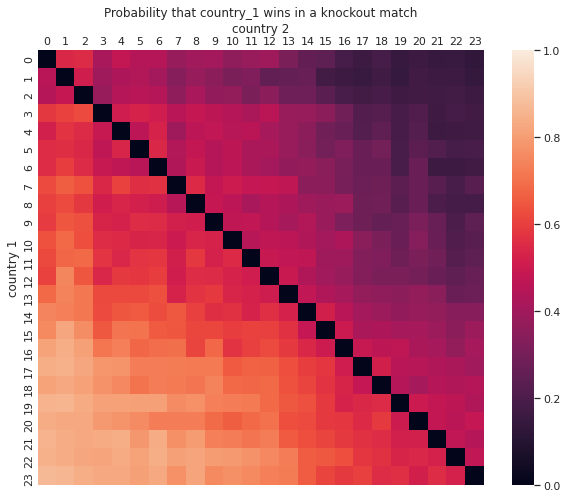

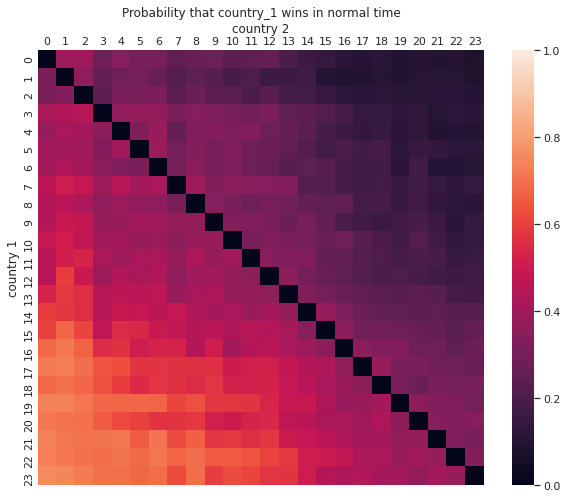

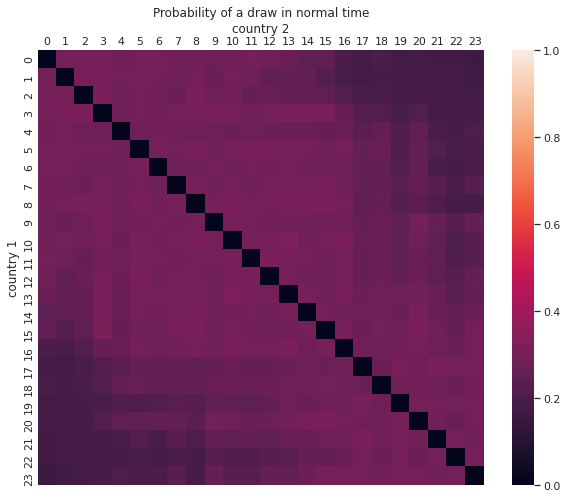

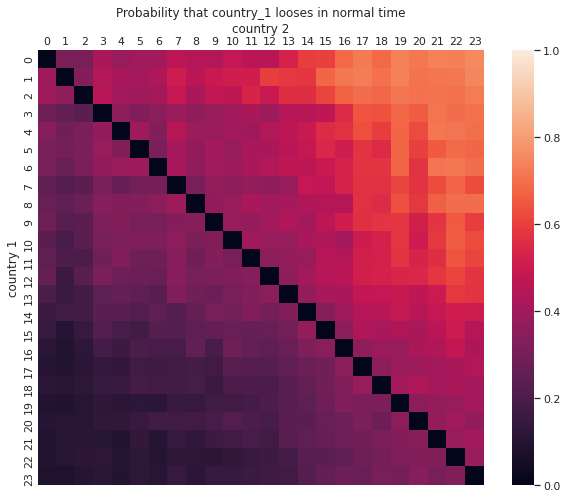

In [6]:
p_knockout_win_matrix = np.zeros(shape=(24, 24))
p_normal_time_win_matrix = np.zeros(shape=(24, 24))
p_normal_time_draw_matrix = np.zeros(shape=(24, 24))
p_normal_time_loss_matrix = np.zeros(shape=(24, 24))

country_id = {country: id for id, country in enumerate(p_match.country_1.unique())}
for index, row in p_match.iterrows():
    c_1, c_2 = country_id[row['country_1']], country_id[row['country_2']]
    p_knockout_win_matrix[c_1, c_2] = row['p_knockout_win']
    p_normal_time_win_matrix[c_1, c_2] = row['p_normal_time_win']
    p_normal_time_draw_matrix[c_1, c_2] = row['p_normal_time_draw']
    p_normal_time_loss_matrix[c_1, c_2] = row['p_normal_time_loss']

plot_matix(p_knockout_win_matrix, 'Probability that country_1 wins in a knockout match', annot=False)
plot_matix(p_normal_time_win_matrix, 'Probability that country_1 wins in normal time', annot=False)
plot_matix(p_normal_time_draw_matrix, 'Probability of a draw in normal time', annot=False)
plot_matix(p_normal_time_loss_matrix, 'Probability that country_1 looses in normal time', annot=False)

#Single Predictions

In [15]:
country_1 = 'Scotland' #@param ['Hungary', 'North Macedonia', 'Finland', 'Slovakia', 'Ukraine', 'Czech Republic', 'Russia', 'Scotland', 'Wales', 'Turkey', 'Sweden', 'Poland', 'Austria', 'Switzerland', 'Croatia', 'Denmark', 'Netherlands', 'Italy', 'Belgium', 'Germany', 'Portugal', 'Spain', 'England', 'France']
country_2 = 'Czech Republic' #@param ['Hungary', 'North Macedonia', 'Finland', 'Slovakia', 'Ukraine', 'Czech Republic', 'Russia', 'Scotland', 'Wales', 'Turkey', 'Sweden', 'Poland', 'Austria', 'Switzerland', 'Croatia', 'Denmark', 'Netherlands', 'Italy', 'Belgium', 'Germany', 'Portugal', 'Spain', 'England', 'France']

target_p_normal_time_win = target_p_normal_time_draw = target_p_normal_time_loss = None
for index, row in p_match.iterrows():
    if (row['country_1'] == country_1 and row['country_2'] == country_2):
        target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss = \
        row['p_normal_time_win'], row['p_normal_time_draw'], row['p_normal_time_loss']
        break

print('target_p_normal_time_win:', target_p_normal_time_win)
print('target_p_normal_time_draw:', target_p_normal_time_draw)
print('target_p_normal_time_loss:', target_p_normal_time_loss)

target_p_normal_time_win: 0.405
target_p_normal_time_draw: 0.29600000000000004
target_p_normal_time_loss: 0.298


In [16]:
def single_prediction(lambda_1, lambda_2):
    poisson_1, poisson_2 = double_poisson_regression(lambda_1, lambda_2, 0)
    poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
    p_normal_time_win, p_normal_time_draw, p_normal_time_loss = p_normal_time(poisson_matrix)
    return p_normal_time_win, p_normal_time_draw, p_normal_time_loss

def cross_entropy_loss(prediction, target):
    return -jnp.mean(jnp.stack(target, axis=-1)*jnp.log(jnp.stack(prediction, axis=-1)), axis=-1)

def train_single_prediction(p_normal_time_win, p_normal_time_draw, p_normal_time_loss):
    def get_loss_for_single_prediction(lambda_1, lambda_2):
        return cross_entropy_loss(single_prediction(lambda_1, lambda_2), (p_normal_time_win, p_normal_time_draw, p_normal_time_loss))

    grad_lambda_1 = grad(get_loss_for_single_prediction, argnums=0)
    grad_lambda_2 = grad(get_loss_for_single_prediction, argnums=1)

    lambda_1 = 1.0
    lambda_2 = 1.0

    losses = [get_loss_for_single_prediction(lambda_1, lambda_2)]
    for _ in range(1000):
        #print(lambda_1, lambda_2)

        grad_1 = -grad_lambda_1(lambda_1, lambda_2)
        grad_2 = -grad_lambda_2(lambda_1, lambda_2)

        #print(grad_1, grad_2)

        lambda_1 += grad_1
        lambda_2 += grad_2

        losses.append(get_loss_for_single_prediction(lambda_1, lambda_2))

    return np.array(losses), lambda_1, lambda_2


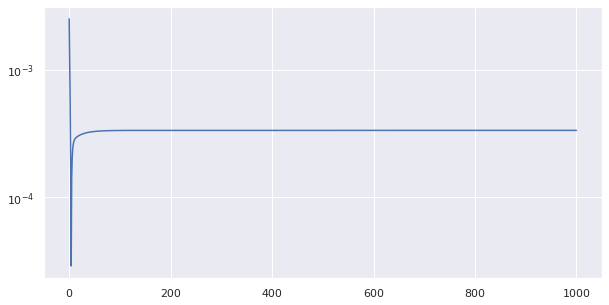

lambda_1: 1.1609580516815186, lambda_2: 0.9513503313064575
0.40540525 0.29629657 0.2982982
0.405 0.29600000000000004 0.298


In [22]:
losses, lambda_1, lambda_2 = train_single_prediction(target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss)
target_entropy = cross_entropy_loss((target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss),
                                    (target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss))
plt.figure(figsize=(10, 5))
plt.semilogy(np.abs(losses - target_entropy))
plt.show()
print(f"lambda_1: {lambda_1}, lambda_2: {lambda_2}")
print(*single_prediction(lambda_1, lambda_2))
print(target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss)

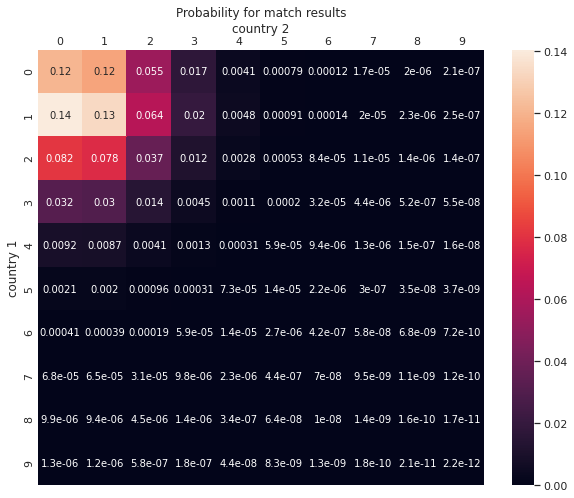

Most probable result is 1:0


In [18]:
poisson_1, poisson_2 = double_poisson_regression(lambda_1, lambda_2, 0)
poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
plot_matix(poisson_matrix, 'Probability for match results', vmax=None)

ml_index = np.argmax(poisson_matrix)
print(f"Most probable result is {ml_index//10}:{ml_index%10}")

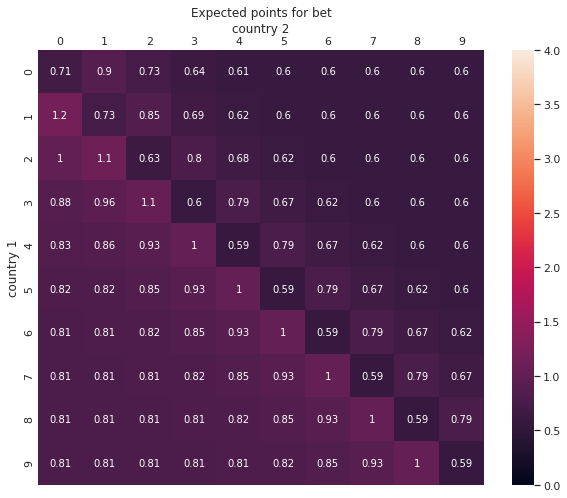

Best bet for Scotland vs. Czech Republic is 1:0


In [19]:
points_matrix = 1*poisson_matrix

points_matrix += 2*win_mask*np.sum(win_mask*poisson_matrix)
points_matrix += 2*draw_mask*np.sum(draw_mask*poisson_matrix)
points_matrix += 2*loss_mask*np.sum(loss_mask*poisson_matrix)

for k in range(-9, 10):
    if k == 0: continue

    diag_shifted = np.eye(10, 10, k=k)
    points_matrix += 1*diag_shifted*np.sum(diag_shifted*poisson_matrix)

plot_matix(points_matrix, 'Expected points for bet', vmax=4)
best_bet_index = np.argmax(points_matrix)

print(f"Best bet for {country_1} vs. {country_2} is {best_bet_index//10}:{best_bet_index%10}")